<a href="https://colab.research.google.com/github/armancohan/cpsc477-internal/blob/main/hw3/part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPSC 477/577 Spring 2025, HW2, Text Generation

## Please write your name and NetID below

NAME:Yuan Chang

NetID:yc2238

## Introduction

This assignment focuses on conditional text generation, or natural language generation (NLG). In the simplest form, the task can be formulated as
$$
y ← g(x)
$$
where $x$ is the input text sequence, $y$ is the output text sequence, $g$ is the neural text generation model.
For example, $x$ can be an English sentence, $y$ can be a Chinese sentence, and then $g$ is a machine translation model.
Similarly, $x$ can be a long news article, $y$ can be a short summary, and then $g$ is text summarization model.
In this homework, we will use text summarization as our target task.

In this assignment, you will learn how to use existing models using the Huggingface library to perform the same task.
You will get familiar with the pipeline for text generation tasks, including training, inference, and evaluation.

**Acknowledgement:** This assignment was designed primarly by former TA of the course, Yixin Liu and further adapted to this semester by current course staff.

## 1. Huggingface Transformers and Datasets

In part 1, you have implemented the Transformer model yourself. For this part, we will use the libraries provided by [Huggingface](https://huggingface.co/), including the famous [Transformers](https://huggingface.co/docs/transformers/index) library and the [Datasets](https://huggingface.co/docs/datasets/index) library.
Let's first install them.

In [3]:
#%pip install transformers
#%pip install datasets
import transformers
import datasets

Let's import the other packages. Please check again to make sure you have the GPU access.

### Using GPU in Colab
PyTorch and other deep learning libraries are much faster using GPU acceleration. For training and evaluating the models in this assignment, you should use a GPU:

Go to Runtime option on the top left
Click Change runtime type
Select "GPU" for Hardware accelerator
Click SAVE button
However, Colab limits the amount of time that you can use a free GPU. So you may wish to implement much of the assignment without the GPU. But note that you will have to run all cells again once you change the runtime type.

Let's first verify which device you are using.

In [7]:
#!pip install transformers datasets evaluate rouge_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor

from typing import Tuple, List

import random
import math
import os
import time
import json
import numpy as np
from collections import Counter

# We'll set the random seeds for deterministic results.
SEED = 1

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

class Placeholder:
    @property
    def DO(self):
        raise NotImplementedError("You haven't yet implemented this part of the assignment yet")

TO = Placeholder()


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Pytorch version is: ", torch.__version__)
print("You are using: ", DEVICE)

Pytorch version is:  2.0.1+cu118
You are using:  cuda


### XSum on Huggingface Datasets

We are going to focus on Text Summarization. Text Summarization is the task of converting a long document into a short summary and is a classic task in NLP.
We will be using a famous dataset called [XSum](https://aclanthology.org/D18-1206.pdf), which is one of the most commonly used datasets for abstractive text summarization.

We will use the Huggingface Datasets library to get our dataset.
Check out their [documentation](https://huggingface.co/docs/datasets/quickstart) for more information.


Below we load XSum using HF Datasets. Please note that it may take a few minutes to load and prepocess the dataset.

We will only use the first 100 examples in the test set of XSum for the following parts to save the computation time.
The entire test set in fact contains more than 10k examples and the training set contains more than 200k examples.

https://huggingface.co/datasets/xsum

In [6]:
import datasets
# get the first 100 data examples in the test split
dataset = datasets.load_dataset("xsum", split="test[:100]",trust_remote_code=True)
# check the dataset information
print(dataset.info.features)

{'document': Value(dtype='string', id=None), 'summary': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None)}


### BART on Huggingface Transformers

The model we are going to use is [BART](https://aclanthology.org/2020.acl-main.703.pdf) (Bidirectional and Auto-Regressive
Transformers), which we covered in class and shares the same model architecture you implemented in part 1.

The specific BART checkpoint we are going to use is first *pre-trained* on large corpora and then already *fine-tuned* on XSum training set.

We are going to use HF Transformers to load this fine-tuned BART checkpoint. HF Transformers hosts more than 10k of different model [checkpoints](https://huggingface.co/models), and make them easily accessible through the library.

As you will see below, first we import [BART](https://huggingface.co/docs/transformers/model_doc/bart) from Transformers, and then load the model parameters with a specific model checkpoint [`facebook/bart-large-xsum`](https://huggingface.co/facebook/bart-large-xsum).

For the following sections, you will want to take a deep look into the related documentaions: [doc1](https://huggingface.co/docs/transformers/model_doc/bart#transformers.BartForConditionalGeneration) and [doc2](https://huggingface.co/docs/transformers/model_doc/bart#transformers.BartTokenizer).

In [8]:
from transformers import BartForConditionalGeneration, BartTokenizer
model_name = "facebook/bart-large-xsum"
tokenizer = BartTokenizer.from_pretrained(model_name)  # load the tokenizer
model = BartForConditionalGeneration.from_pretrained(model_name).to(DEVICE)  # load the model

## Dataloader

### The data pipeline

For training or inferencing any model, we first need to transform the raw textual data into model input. As we saw in part1, the model can work with lists of token ids, and for faster processing we always batch the data examples.
This can be done in pytorch using a "DataLoader"

Let's define a dataloader that transforms the data examples into batches of model input.
While we have provided the implementation for you, please make sure you understand the purpose and logic of the function, which is critical for you to finish the following sections.

In [4]:
def dataloader(batch_size):
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        articles = tokenizer(
                batch["document"],
                return_tensors="pt",
                padding="longest",
                add_special_tokens=True,
                truncation=True,
                max_length=512,
            ).to(DEVICE)
        input_ids = articles["input_ids"]
        attention_mask = articles["attention_mask"]
        summaries = tokenizer(
                batch["summary"],
                return_tensors="pt",
                padding="longest",
                add_special_tokens=True,
                truncation=True,
                max_length=128,
            ).to(DEVICE)
        target_input_ids = summaries["input_ids"]
        target_attention_mask = summaries["attention_mask"]
        yield {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "target_input_ids": target_input_ids,
            "target_attention_mask": target_attention_mask,
            "articles": batch["document"],
            "summaries": batch["summary"],
        }

## 2. Training Text Summarization Models

In this section we are going to look into the training process of text summarization models.
The standard training algorithm for text summarization model is Maximum Likelihood Estimation (MLE), and the loss function for this training algorithm is the cross-entropy loss:
$$
L_{CE} = - \sum_{i=1}^l \log p_{model}(\tilde{w}_i|\tilde{w}_{0, ..., i-1}, D),
$$
where $D$ is the input document, $\tilde{w}$ is the *reference* summary (the summary in our training data that we want the model to predict), with length $l+1$ including $\tilde{w}_0$ always set to a special token **BOS** (begin-of-sequence), and $\tilde{w}_i$ is the $i$-th token.
Note that this training algorithm is also called *teacher-forcing*, since the model is required to predict the $i$-th token of the reference summary given the prefix of the reference summary before the $i$-th token.

To train the summarization model, we will take a batch of data examples and compute the loss in the *forward step*, and take the gradient of the model parameters w.r.t. the loss function in the *backward step*, then use an optimization algorithm (e.g., gradient descent) to update the model parameters.
Usually such a training process can take a long time.
Due to the computation resource limitations, for this assigment we will only implement the forward step below.
In the next block, you are going to implement a function `compute_loss`, which computes the cross-entropy loss given a batch of input data points and a summarization model and returns the computed loss.
Please note:
1. The computed loss should be averaged over all tokens.
2. The padding token (PAD) should be ignored in computation.
3. You should not pass in the `labels` argument when you call the forward function of the model.

In [8]:
def compute_loss(model, batch):
    """
    Args:
        model: the summarization model
        batch: a batch of data from the dataloader

    Return:
        loss: the computed average loss
    """
    # TODO: Implement
    input_ids = batch["input_ids"].squeeze(0)
    attention_mask = batch["attention_mask"].squeeze(0)
    target_input_ids = batch["target_input_ids"].squeeze(0)


    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    output_logits = outputs.logits[:, :target_input_ids.shape[1], :]


    print("Logits shape:", output_logits.shape) 
    print("Target shape:", target_input_ids.shape)
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, reduction="mean")
    loss = loss_fn(output_logits.reshape(-1, output_logits.size(-1)), target_input_ids.reshape(-1))

    return loss

Let's test the loss of the pretrained and finetuned BART model! The loss should be exactly 1.6260 (although a little rounding error is allowed.)

In [9]:
batches = dataloader(batch_size=8)
batch = next(batches) # get one batch of data
model = model.eval()
with torch.no_grad():
    loss = compute_loss(model, batch)
print(loss)

Logits shape: torch.Size([8, 32, 50264])
Target shape: torch.Size([8, 32])
tensor(11.3236, device='cuda:0')


## 3. Text Summarization Evaluation

In this section we will focus on the **evaluation** of text summarization models.

Having trained a summarization model, an important question is **how good the model is?**
To answer this question, we will need to perform the following steps:

1. Using the summarization model to generate the *candidate summaries* on the *test set*. This procedure is also called as **inference**.
For an autoregressive NLG model as BART, at one inference step $t$ it predicts the probabiltiy distribution of the next token based on its *own* previously predicted tokens $\hat{w}_{0, ..., t-1}$ and the input document $D$:
$$
p_t(w_i) = p_{model}(w_i|\hat{w}_{0, ..., t-1}, D),
$$
where $w_i$ stands for a possible token in the vocabulary.
The actual token as time stamp $t$ depends on the specific **decoding algorithm**.
For example, if *greddy decoding* is used, then we select the most probable token according to $p_t$:
$$
\hat{w_t} = \arg \max_{w_i} p_t(w_i).
$$
Later we will explore other decoding algorithms that can yield better results.

2. Having obtained the candidate (system-generated) summaries on the test set, we evalaute the quality of the candidate summaries against the reference summaries provided in the dataset.
This can be achieved by either *human evaluation* or *automatic evaluation* with **automatic evaluation metrics**. The evaluation result for one summarization model is usually a numerical score, which can be the quality score of its generated summaries over the test set.
Then, we can compare the performance of different summarization models by comparing their evaluation scores.

### ROUGE for Automatic Summarization Evaluation

In this part, we are going to evaluate the quality of the summaries using the [ROUGE](https://aclanthology.org/W04-1013.pdf) evaluation metric. Rouge is among the most widely used automatic evaluation metrics for text summarization.

While there are more than 100 [variants](https://aclanthology.org/D15-1013.pdf) of ROUGE, we are going to use its most basic settings: ROUGE-N, which is based on n-grams matching between the reference and candidate summaries.
Concretely, the ROUGE-N recall score is as follows:
$$
\textrm{ROUGE-N}_{R} =\frac{\sum_{m \in \mathcal{M}_n} \mathrm{Count}_{\mathrm{Match}}(m)}{\sum_{m \in \mathcal{M}_n} \mathrm{Count}(m)},
$$
where $\mathcal{M}_n$ is the set of unique $n$-grams in the reference summary, $\mathrm{Count}(m)$ is the number of occurrence of n-gram $m$ in the reference summary, $\mathrm{Count}_{\mathrm{Match}}(m)$ is the number of co-occurrence of n-gram $m$ in both the reference summary and candidate summary.

The ROUGE precision score can be defined by replacing the role of reference and candidate summary. Then we can compute the ROUGE [F1](https://en.wikipedia.org/wiki/F-score) score. Please note that ROUGE score is defined at the summary level, and the model performance can be evaluated by averaging over the ROUGE score of its generated summaries over the entire test set.

We can use Huggingface to calculate the rouge score.


Having implemented ROUGE, we will use it to evaluate the performance of the pre-trained BART on XSum.
To do that, we first let the model generate the candidate summaries (the **inference** step).

In [10]:
from tqdm import tqdm
# first we predict the summaries and store them in a list
# we also store the actual summaries in another list
# we then compare the predicted summaries to the actual summaries using the ROUGE metric
batch_size = 8
batches = dataloader(batch_size=batch_size)  # get batches
total_batches = len(dataset) // batch_size

model = model.eval()
candidates = []
references = []
with torch.no_grad():
    for (i, batch) in enumerate(tqdm(batches, total=total_batches)):
        summary_ids = model.generate(batch["input_ids"], num_beams=6, max_length=62)  # inference
        summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)  # decoding
        candidates.extend(summaries)
        references.extend(batch["summaries"])

13it [00:19,  1.47s/it]                        


Finally, we use ROUGE to evaluate the quality of the candidate summaries.
We provide a tokenization function that tokenizes the summaries as a pre-processing before ROUGE.

In [8]:
# evaluate the rouge score
import evaluate

rouge = evaluate.load('rouge')

results = rouge.compute(predictions=candidates, references=references)
print(results)

{'rouge1': 0.44060171415624283, 'rouge2': 0.21698310729156262, 'rougeL': 0.3677778665115801, 'rougeLsum': 0.3679799523953854}


Here are the reference ROUGE scores for your reference:

ROUGE-1 F1: 44.037
ROUGE-2 F1: 21.686
ROUGE-L F1: 36.991
ROUGELsum F1: 36.990

## 4. Decoding Algorithms

Recall from the previous section that the first step we are going to perform when evalauting NLG models is to use the summarization model to generate the *candidate summaries* on the *test set*. This procedure is also called as **inference**.

For an autoregressive NLG model as BART, at one inference step $t$ it predicts the probabiltiy distribution of the next token based on its *own* previously predicted tokens $\hat{w}_{0, ..., t-1}$ and the input document $D$:
$$
p_t(w_i) = p_{model}(w_i|\hat{w}_{0, ..., t-1}, D),
$$
where $w_i$ stands for a possible token in the vocabulary.
The actual token as time stamp $t$ depends on the specific **decoding algorithm**.

In this section, you are going to implement several different decoding algorithms:

1. Greedy Decoding
2. Sampling
3. Beam Search

**Note:** While most of the Huggingface NLG models have a `.generate()` function supporting different decoding algorithms, you are going to implement the algorithms yourself without using this function.

Before you start the following sections, one thing to keep in mind is *when* should the generation stop.
In our case, it stops when either a pre-defined condition is reached (e.g. a maximum generation length), or a special **end-of-sequence (EOS)** token is predicted as the next token.
You can get the index of this token via `tokenizer.eos_token_id`.
You can also access the BOS token and PAD token in similar manners.

**Note**: in the following sections, we always assume the generated summary starts with a BOS token and ends with a EOS token, and the summary length is counted with both of them.

Before we going to the next sections, let's first define an evaluation function using ROUGE. We will use a reference ROUGE implementation instead for consistent results.

In [12]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3'],
                                  use_stemmer=False, split_summaries=False)

def evaluate_rouge(candidates, references):
    scores = [scorer.score(x, y) for x, y in zip(references, candidates)]
    for n in range(1, 4):
        f1, prec, recall, cnt = 0, 0, 0, 0
        for score in scores:
            f1 += score[f"rouge{n}"].fmeasure
            prec += score[f"rouge{n}"].precision
            recall += score[f"rouge{n}"].recall
            cnt += 1
        print(f"ROUGE-{n} F1: {f1:.3f}, Precision: {prec:.3f}, Recall: {recall:.3f}")

### Greedy Decoding

When greddy decoding is used, we select the most probable token according to $p_t$:
$$
\hat{w_t} = \arg \max_{w_i} p_t(w_i).
$$
Please implement the algorithm below.

In [ ]:
def greedy_decode(model, input_ids, attention_mask, tokenizer, max_length=62):
    """Greedy decoding
    Args:
        model: the model to use
        input_ids: the input ids, shape [batch_size, seq_len]
        attention_mask: the attention mask, shape [batch_size, seq_len]
        max_length: the maximum length of the generated summary, including the <bos> and <eos> tokens
    Returns:
        the generated summary
    """
    # TODO: Implement
    model = model.eval()
    batch_size = input_ids.shape[0]
    if attention_mask.shape[0] != batch_size:
        attention_mask = attention_mask[:batch_size]


    decoded_summaries = torch.full((batch_size, 1), tokenizer.bos_token_id, dtype=torch.long, device=input_ids.device)
    for i in range(max_length-1):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=decoded_summaries)
        next_token_logits = outputs.logits[:, -1, :]
        
        next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
        decoded_summaries = torch.cat([decoded_summaries, next_token_id], dim=-1)
        if torch.all(next_token_id == tokenizer.eos_token_id):
            break
    return [tokenizer.decode(summary.tolist(), skip_special_tokens=True) for summary in decoded_summaries]



Let's test it.

In [37]:
batches = dataloader(batch_size=8)  # get batches

candidates = []
references = []
with torch.no_grad():
    for (i, batch) in enumerate(batches):
        print(f"batch {i+1}")
        summaries = greedy_decode(model, batch["input_ids"], batch["attention_mask"], tokenizer)
        candidates.extend(summaries)
        references.extend(batch["summaries"])

evaluate_rouge(candidates, references)

batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
ROUGE-1 F1: 40.859, Precision: 42.771, Recall: 40.597
ROUGE-2 F1: 18.310, Precision: 19.132, Recall: 18.290
ROUGE-3 F1: 9.719, Precision: 10.112, Recall: 9.756


Now you are going to implement the sampling algorithm, which samples the next token according to the probability $p_t(w_i)$.

In [44]:
def sampling(model, input_ids, attention_mask, tokenizer, max_length=62):
    """Sample decoding
    Args:
        model: the model to use
        input_ids: the input ids, shape [batch_size, seq_len]
        attention_mask: the attention mask, shape [batch_size, seq_len]
        max_length: the maximum length of the generated summary, including the <bos> and <eos> tokens
    Returns:
        the generated summary
    """
    # TODO: Implement
    model = model.eval()
    batch_size = input_ids.shape[0]
    if attention_mask.shape[0] != batch_size:
        attention_mask = attention_mask[:batch_size]

    decoded_summaries = torch.full((batch_size, 1), tokenizer.bos_token_id, dtype=torch.long, device=input_ids.device)
    for i in range(max_length-1):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=decoded_summaries)
        next_token_logits = outputs.logits[:, -1, :]
        next_token_id = torch.multinomial(F.softmax(next_token_logits, dim=-1), 1) # using multinomial to implement sampling algorithm


        decoded_summaries = torch.cat([decoded_summaries, next_token_id], dim=-1)
        if torch.all(next_token_id == tokenizer.eos_token_id):
            break
    return [tokenizer.decode(summary.tolist(), skip_special_tokens=True) for summary in decoded_summaries]

Let's test it.

In [45]:
batches = dataloader(batch_size=8)  # get batches

candidates = []
references = []
with torch.no_grad():
    for (i, batch) in enumerate(batches):
        print(f"batch {i+1}")
        summaries = sampling(model, batch["input_ids"], batch["attention_mask"], tokenizer)
        candidates.extend(summaries)
        references.extend(batch["summaries"])

evaluate_rouge(candidates, references)

batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
ROUGE-1 F1: 21.951, Precision: 17.586, Recall: 30.527
ROUGE-2 F1: 6.345, Precision: 5.043, Recall: 8.936
ROUGE-3 F1: 2.566, Precision: 2.009, Recall: 3.746


Now you are going to implement the Beam Search algorithm.

One important hyper-parameter of Beam Search is **beam_size**.
Specifically, let **beam_size** to be $n$, Beam Search maintains $n$-possible candidates during search. The candidates are selected by the following scoring function:
$$
f(\hat{w}) = \frac{\sum_{t=1}^{l} \log p_{model}(\hat{w}_t|\hat{w}_{0, ..., t-1}, D)}{l^α},
$$
where $\hat{w}$ is a (partial-)candidate summary generated so far of which the length is $l+1$.
$\alpha$ is another important parameter for *length penalty*.
Specifically, when $\alpha=1$, $f(\hat{w})$ is the average token-level log-probability.
When $\alpha=0$, $f(\hat{w})$ is the sequence-level log-probability.

While there are multiple variants of Beam Search ([reference](https://aclanthology.org/W17-3207.pdf)), we are going to implement its most basic form with three arguments controlling the algorithm behavior: the **beam_size** $n$, the **length peanlty factor** $\alpha$, and the maximum summary length.

Please also note that when one of the candidate reaches the EOS token, it means that the search on this candidate is complete. You should maintain this completed candidate until there are at least $n$ other possible candidates with higher scores.

Now you are going to implement Beam Search below:

In [18]:
def beam_search(model, input_ids, attention_mask, tokenizer, max_length=62, beam_size=6, length_penalty=1.0):
    """Beam search decoding
    Args:
        model: the model to use
        input_ids: the input ids, shape [batch_size, seq_len]
        attention_mask: the attention mask, shape [batch_size, seq_len]
        max_length: the maximum length of the generated summary, including the <bos> and <eos> tokens
        beam_size: the beam size
        length_penalty: the length penalty
    Returns:
        the generated summary
    """
    model = model.eval()
    batch_size = input_ids.shape[0]
    if attention_mask.shape[0] != batch_size:
        attention_mask = attention_mask[:batch_size]
    expanded_input_ids = input_ids.repeat_interleave(beam_size, dim=0) 
    expanded_mask = attention_mask.repeat_interleave(beam_size, dim=0) 

    expanded_decoder_input_ids = torch.full(
        (batch_size * beam_size, 1), tokenizer.bos_token_id, dtype=torch.long, device=input_ids.device
    )

    
    print("expanded_input_ids shape:", expanded_input_ids.shape)  
    print("expanded_mask shape:", expanded_mask.shape)  
    print("expanded_decoder_input_ids shape:", expanded_decoder_input_ids.shape) 

    beam_scores = torch.zeros(batch_size * beam_size, device=input_ids.device)

    for step in range(max_length - 1):
        outputs = model(
            input_ids=expanded_input_ids, 
            attention_mask=expanded_mask, 
            decoder_input_ids=expanded_decoder_input_ids
        )

        logits = outputs.logits[:, -1, :]  
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)  

       
        scores = beam_scores.unsqueeze(-1) + log_probs 
        scores = scores.view(batch_size, beam_size * logits.shape[-1])  
        top_scores, top_indices = torch.topk(scores, beam_size, dim=-1) 
        beam_indices = top_indices // logits.shape[-1]  
        next_tokens = top_indices % logits.shape[-1]  
        expanded_decoder_input_ids = expanded_decoder_input_ids[beam_indices]  
        expanded_decoder_input_ids = torch.cat([expanded_decoder_input_ids, next_tokens.unsqueeze(-1)], dim=-1)  
        beam_scores = top_scores.view(-1)

       
        if torch.all(next_tokens == tokenizer.eos_token_id):
            final_scores = beam_scores / (expanded_decoder_input_ids.shape[1] ** length_penalty)
    best_beams = expanded_decoder_input_ids[torch.argmax(final_scores, dim=-1)]
    decoded_summaries = [tokenizer.decode(beam.tolist(), skip_special_tokens=True) for beam in best_beams]

    return decoded_summaries



Let's test it.

In [19]:
%%time
batches = dataloader(batch_size=8)  # get batches

candidates = []
references = []
with torch.no_grad():
    for (i, batch) in enumerate(batches):
        print(f"batch {i+1}")
        summaries = beam_search(model, batch["input_ids"], batch["attention_mask"], tokenizer,
                                max_length=62, beam_size=6, length_penalty=1.0)
        candidates.extend(summaries)
        references.extend(batch["summaries"])

evaluate_rouge(candidates, references)


batch 1
expanded_input_ids shape: torch.Size([48, 512])
expanded_mask shape: torch.Size([48, 512])
expanded_decoder_input_ids shape: torch.Size([48, 1])


RuntimeError: The size of tensor a (2) must match the size of tensor b (6) at non-singleton dimension 2

Finally, we are going to analyze the behavior of Beam Search w.r.t. the beam size and the length peanlty factor.
Now we are going to use the model's builtin `generate` function for better consistency.
Below is a wrapper for this function.

In [10]:
def beam_search_ref(model, input_ids, attention_mask, tokenizer, max_length=62, beam_size=4, length_penalty=1.0):
    """Beam search decoding
    Args:
        model: the model to use
        input_ids: the input ids, shape [batch_size, seq_len]
        attention_mask: the attention mask, shape [batch_size, seq_len]
        max_length: the maximum length of the generated summary, including the <bos> and <eos> tokens
        beam_size: the beam size
        length_penalty: the length penalty
    Returns:
        the generated summary
    """
    return model.generate(input_ids, num_beams=beam_size, max_length=max_length, length_penalty=length_penalty)

Now please do a hyper-parameter search for the beam size with range [1, 10], and the length penalty with range [0.5, 2.0].
Plot the ROUGE1 F1 score w.r.t. both different beam sizes and length penalties in a 3d plot (e.g., https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html), and provide a hyper-parameter configuration such that the ROUGE1 F1 score is at least 43.8.

Testing beam_size=1, length_penalty=0.50...


c:\Users\jackchang\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:649: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
c:\Users\jackchang\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:668: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `0.5` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


Testing beam_size=1, length_penalty=0.67...


c:\Users\jackchang\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:668: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `0.6666666666666666` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


Testing beam_size=1, length_penalty=0.83...


c:\Users\jackchang\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:668: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `0.8333333333333333` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


Testing beam_size=1, length_penalty=1.00...
Testing beam_size=1, length_penalty=1.17...


c:\Users\jackchang\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:668: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `1.1666666666666665` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


Testing beam_size=1, length_penalty=1.33...


c:\Users\jackchang\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:668: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `1.3333333333333333` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


Testing beam_size=1, length_penalty=1.50...


c:\Users\jackchang\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:668: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `1.5` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


Testing beam_size=1, length_penalty=1.67...


c:\Users\jackchang\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:668: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `1.6666666666666665` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


Testing beam_size=1, length_penalty=1.83...


c:\Users\jackchang\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:668: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `1.8333333333333333` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


Testing beam_size=1, length_penalty=2.00...


c:\Users\jackchang\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:668: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `2.0` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


Testing beam_size=2, length_penalty=0.50...
Testing beam_size=2, length_penalty=0.67...
Testing beam_size=2, length_penalty=0.83...
Testing beam_size=2, length_penalty=1.00...
Testing beam_size=2, length_penalty=1.17...
Testing beam_size=2, length_penalty=1.33...
Testing beam_size=2, length_penalty=1.50...
Testing beam_size=2, length_penalty=1.67...
Testing beam_size=2, length_penalty=1.83...
Testing beam_size=2, length_penalty=2.00...
Testing beam_size=3, length_penalty=0.50...
Testing beam_size=3, length_penalty=0.67...
Testing beam_size=3, length_penalty=0.83...
Testing beam_size=3, length_penalty=1.00...
Testing beam_size=3, length_penalty=1.17...
Testing beam_size=3, length_penalty=1.33...
Testing beam_size=3, length_penalty=1.50...
Testing beam_size=3, length_penalty=1.67...
Testing beam_size=3, length_penalty=1.83...
Testing beam_size=3, length_penalty=2.00...
Testing beam_size=4, length_penalty=0.50...
Testing beam_size=4, length_penalty=0.67...
Testing beam_size=4, length_pena

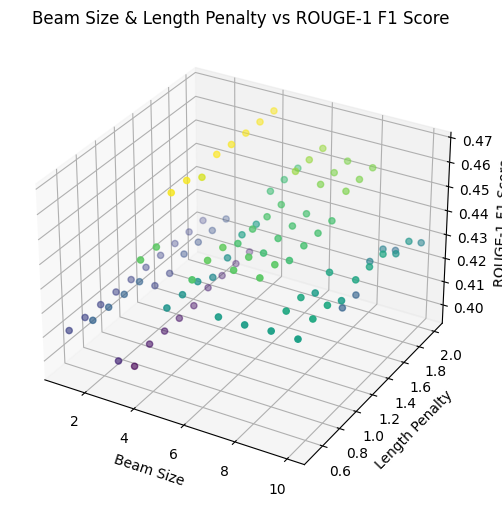

Best Hyperparameters: {'beam_size': 4, 'length_penalty': 1.3333333333333333, 'rouge1_f1': 0.466967594096077}


In [13]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
GOOD_HYPER_PARAMETERS = {
    "beam_size": -1,
    "length_penalty": 0,
}   #  TODO:
beam_sizes = list(range(1, 11))
length_penalties = np.linspace(0.5, 2.0, 10)
results = []
best_params = {"beam_size": -1, "length_penalty": 0, "rouge1_f1": 0}

batch = next(iter(dataloader(batch_size=8)))
input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"]
references = batch["summaries"]

for beam_size, length_penalty in product(beam_sizes, length_penalties):
    print(f"Testing beam_size={beam_size}, length_penalty={length_penalty:.2f}...")
    summaries = beam_search_ref(model, input_ids, attention_mask, tokenizer, 
                                    beam_size=beam_size, length_penalty=length_penalty)
    summaries = [tokenizer.decode(summary.tolist(), skip_special_tokens=True) for summary in summaries]


    rouge_scores = [scorer.score(ref, cand) for ref, cand in zip(references, summaries)]
    rouge1_f1, rouge2_f1, rouge3_f1 = 0, 0, 0
    count = len(rouge_scores)
    for score in rouge_scores:
        rouge1_f1 += score["rouge1"].fmeasure
        rouge2_f1 += score["rouge2"].fmeasure
        rouge3_f1 += score["rouge3"].fmeasure
    if count > 0:
        rouge1_f1 /= count
        rouge2_f1 /= count
        rouge3_f1 /= count
    results.append((beam_size, length_penalty, rouge1_f1))


    if rouge1_f1 >= 0.438 and rouge1_f1 > best_params["rouge1_f1"]:
        best_params = {"beam_size": beam_size, "length_penalty": length_penalty, "rouge1_f1": rouge1_f1}
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

beam_size_vals, length_penalty_vals, rouge1_f1_vals = zip(*results)
ax.scatter(beam_size_vals, length_penalty_vals, rouge1_f1_vals, c=rouge1_f1_vals, cmap="viridis", marker="o")
ax.set_xlabel("Beam Size")
ax.set_ylabel("Length Penalty")
ax.set_zlabel("ROUGE-1 F1 Score")
ax.set_title("Beam Size & Length Penalty vs ROUGE-1 F1 Score")
plt.show()
print("Best Hyperparameters:", best_params)


### Top-p Sampling

In addition to the basic decoding strategies you've implemented, you'll now implement nucleus sampling (also known as top-p sampling). This decoding strategy helps balance between the deterministic nature of greedy/beam search and the potential randomness of pure sampling.
For top-p sampling, at each step we:

- Sort the vocabulary by probability  
- Keep only the minimal set of tokens whose cumulative probability exceeds p  
- Renormalize the probabilities of this reduced set  
- Sample from this renormalized distribution  

In [14]:
def nucleus_sampling(model, input_ids, attention_mask, tokenizer, max_length=62, p=0.9):
    """Nucleus (top-p) sampling
    Args:
        model: the model to use
        input_ids: the input ids, shape [batch_size, seq_len]
        attention_mask: the attention mask, shape [batch_size, seq_len]
        max_length: the maximum length of the generated summary
        p: the cumulative probability threshold (typically 0.9 or 0.95)
    Returns:
        the generated summary
    """
    # TODO: Implement
    model = model.eval()
    batch_size = input_ids.shape[0]
    if attention_mask.shape[0] != batch_size:
        attention_mask = attention_mask[:batch_size]
    generated = torch.full((batch_size, 1), tokenizer.bos_token_id, dtype=torch.long, device=input_ids.device)
    for i in range(max_length - 1):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=generated)
        logits = outputs.logits[:, -1, :] 
        probs = F.softmax(logits, dim=-1) 

        sorted_probs, sorted_indices = torch.sort(probs, descending=True)  
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)  
        mask = cumulative_probs <= p  # Keep only the minimal set of tokens whose cumulative probability exceeds p
        mask[..., 1:] = mask[..., :-1].clone()
        mask[..., 0] = True  
        filtered_probs = sorted_probs * mask  
        filtered_probs /= filtered_probs.sum(dim=-1, keepdim=True) 
        sampled_indices = torch.multinomial(filtered_probs, 1)
        next_token = sorted_indices.gather(-1, sampled_indices)
        generated = torch.cat([generated, next_token], dim=-1)
        if torch.all(next_token == tokenizer.eos_token_id):
            break

    return  [tokenizer.decode(seq.tolist(), skip_special_tokens=True) for seq in generated]
    

In [15]:
# Test your implementation

batches = 
](batch_size=8)  # get batches

candidates = []
references = []
with torch.no_grad():
    for (i, batch) in enumerate(batches):
        print(f"batch {i+1}")
        summaries = nucleus_sampling(model, batch["input_ids"],
                                   batch["attention_mask"], tokenizer, p=0.9)
        candidates.extend(summaries)
        references.extend(batch["summaries"])

evaluate_rouge(candidates, references)

batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
ROUGE-1 F1: 28.266, Precision: 23.461, Recall: 37.064
ROUGE-2 F1: 11.155, Precision: 9.209, Recall: 14.771
ROUGE-3 F1: 5.541, Precision: 4.541, Recall: 7.440


### Reflection quessons

1: When implementing the compute_loss function, you used teacher forcing (providing the reference summary tokens during training). What are potential limitations of this training approach? How might this create a mismatch between training and inference?

TODO: Using teacher forcing might let the model learn the information by the reference, leading to the model generating nothing and inference nothing.


2: Looking at the BART model architecture used in this assignment, how does it compare to the Transformer you implemented in Part 1? What additional components or modifications does BART introduce and why are they useful for summarization?

TODO: Bart use the full encoder-decoder architecture. This helps capture richer contextual information, making it better at understanding the input document before summarization.